# Stocks news ingestion

> <b> Steps </b>
> * [project creation and prerequisits](#project-creation-and-prerequisits)
> * [Deploying sentiment analysis serving function from the function marketplace](#Deploying-sentiment-analysis-serving-function-from-the-function-marketplace)
> * [Creating a feature set and declaring the graph](#Creating-a-feature-set-and-declaring-the-graph)
> * [Dummy ingestion, Deploying ingestion service and getting ingestion endpoint](#Dummy-ingestion,-Deploying-ingestion-service-and-getting-ingestion-endpoint)
> * [Testing ingestion service](#Testing-ingestion-service)
> * [Creating scheduled mlrun job to invoke our function every time delta](#Creating-scheduled-mlrun-job-to-invoke-our-function-every-time-delta)

## project creation and prerequisits

In [1]:
# !/User/align_mlrun.sh

In [2]:
# install prerequsits 
# prerequisits for the notebook is installing 2 packages yfinance yahoo_fin for uploading stocks data 
import importlib.util
import IPython

def install_missing_packages(packages):
    install_flag = False
    for package in packages:
        spec = importlib.util.find_spec(package)
        if spec is None:
            %pip install {package}
            install_flag = True
        else:     
            print("package {} installed".format(package))
        if install_flag:            
            print ("restarting kernerl due to package install")
            IPython.Application.instance().kernel.do_shutdown(True)
# For illustrative purposes.
packages  = ['yfinance', 'yahoo_fin']
install_missing_packages(packages)

package yfinance installed
package yahoo_fin installed


In [3]:
import mlrun
project = mlrun.get_or_create_project(name='stocks',user_project=True, context="src/")

> 2022-08-10 06:32:57,345 [info] loaded project stocks from MLRun DB


In [4]:
NUMBER_OF_STOCKS = 10

In [5]:
import os

# getting the sentiment analysis pretrained model (433M might take a while)
if not os.path.exists('src/model.pt'): 
    os.makedirs('src',exist_ok=True)
    print('getting model')
    !wget -O src/model.pt https://iguazio-sample-data.s3.amazonaws.com/models/model.pt 

## Deploying sentiment analysis serving function from the function marketplace

In [6]:
model_location = os.path.abspath('src/model.pt')
sentiment_analysis_serving = mlrun.import_function('hub://sentiment_analysis_serving').apply(mlrun.auto_mount())
sentiment_analysis_serving.add_model('sentiment_analysis_model', model_path=model_location,
                                      class_name='SentimentClassifierServing')

# sentiment_analysis_serving.with_http() # needed to provide http-endpoint to our serving graph

sentiment_analysis_serving.set_tracking()
sentiment_analysis_serving.spec.readiness_timeout = 3600
address = sentiment_analysis_serving.deploy()
print(address)

> 2022-08-10 06:32:57,700 [info] Starting remote function deploy
2022-08-10 06:33:00  (info) Deploying function
2022-08-10 06:33:00  (info) Building
2022-08-10 06:33:01  (info) Staging files and preparing base images
2022-08-10 06:33:01  (info) Building processor image
2022-08-10 06:35:07  (info) Build complete
> 2022-08-10 06:36:37,680 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-dani-sentiment-analysis-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-dani-sentiment-analysis-serving-stocks-dani.default-tenant.app.vmdev93.lab.iguazeng.com/']}
http://stocks-dani-sentiment-analysis-serving-stocks-dani.default-tenant.app.vmdev93.lab.iguazeng.com/


## Creating a feature set and declaring the graph

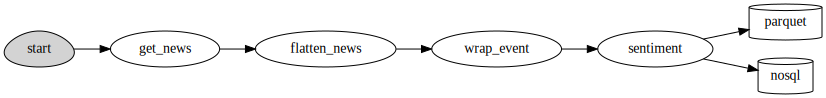

In [7]:
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import DateExtractor, MapValues
import yahoo_fin.stock_info as si

# creating feature set
news_set = fstore.FeatureSet("news", 
                                 entities=[fstore.Entity("ticker")],
                                 timestamp_key='Datetime', 
                                 description="stocks news feature set")

# setting up the graph
news_set.graph \
    .to(name='get_news', handler='get_news') \
    .to("storey.steps.Flatten", name="flatten_news") \
    .to(name='wrap_event', handler='wrap_event') \
    .to("sentiment_analysis", "sentiment", full_event=True, address=address) 

news_set.set_targets(with_defaults=True) 
news_set.plot(rankdir="LR", with_targets=True)

## Dummy ingestion, Deploying ingestion service and getting ingestion endpoint

In [8]:
# ingesting dummy (A MUST) 
import os
import datetime
import pandas as pd
# because were ingesting locally, code must be present !
from src.news import *

name = os.environ['V3IO_USERNAME']
now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

fstore.ingest(news_set,
              pd.DataFrame.from_dict({'ticker':[name],
                                      'Datetime': now,
                                      'n_stocks':NUMBER_OF_STOCKS}))

Datetime            published  \
ticker                                            
A      2022-08-09 14:00:02  2022-08-09 14:00:02   
A      2022-08-04 13:55:01  2022-08-04 13:55:01   
A      2022-08-02 21:25:09  2022-08-02 21:25:09   
A      2022-08-02 12:30:00  2022-08-02 12:30:00   
A      2022-08-02 12:07:00  2022-08-02 12:07:00   
...                    ...                  ...   
ADBE   2022-07-27 13:42:00  2022-07-27 13:42:00   
ADBE   2022-07-27 13:00:01  2022-07-27 13:00:01   
ADBE   2022-07-25 13:02:45  2022-07-25 13:02:45   
ADBE   2022-07-25 09:42:09  2022-07-25 09:42:09   
ADBE   2022-07-24 12:00:00  2022-07-24 12:00:00   

                                                  summary  \
ticker                                                      
A       Agilent A doesnt possess the right combination...   
A       Itron ITRI delivered earnings and revenue surp...   
A       Cognex Corporation CGNX delivered earnings and...   
A       SANTA CLARA Calif August 02 2022Agilent Techno...   
A       SANTA CLARA Calif August 02 2022Agilent Techno...   
...                                                   ...   
ADBE    After enduring its worst first half of the yea...   
ADBE    Zackscom users have recently been watching Ado...   
ADBE    Andvari Associates an investment management fi...   
ADBE    Apple Adobe and Advanced Micro Devices have be...   
ADBE    Amid the massive drop in tech stocks investor ...   

                                                    title  sentiment  
ticker                                                                
A       Agilent Technologies A Reports Next Week Wall ...        0.5  
A       Itron ITRI Q2 Earnings and Revenues Miss Estim...        0.0  
A       Cognex Corporation CGNX Lags Q2 Earnings Estim...        1.0  
A       Agilent Acquires Polymer Standards Service Bro...        0.0  
A       Agilent Announces Thought Leader Award to Gerh...        1.0  
...                                                   ...        ...  
ADBE            3 Nasdaq 100 Stocks to Buy Hand Over Fist        0.0  
ADBE    Investors Heavily Search Adobe Inc ADBE Here i...        1.0  
ADBE                   Is Adobe ADBE a Smart LongTerm Buy        0.0  
ADBE    Zacks Investment Ideas feature highlights Appl...        0.5  
ADBE    Market Got You Down Consider Investing in Thes...        0.0  

[200 rows x 5 columns]

In [9]:
# Deploying ingestion service
# Define the HTTP Source to_dictable the HTTP trigger on our function and expose the endpoint.
# There is an option to declare key and timestamp inside the http source (here we dont send data through the http hence not needed)
http_source = mlrun.datastore.sources.HttpSource()
news_set.spec.source = http_source

# code_to_function our mlrun wrapped function to deploy the ingestion pipeline on.
# the serving runtimes enables the deployment of our feature set's computational graph
function = mlrun.code_to_function(name='get_news',kind='serving',image='mlrun/mlrun', requirements=['yahoo_fin','graphviz'], filename='src/news.py')

function.spec.readiness_timeout = 3600

run_config = fstore.RunConfig(function=function, local=False).apply(mlrun.mount_v3io())

# Deploying
news_set_endpoint = fstore.deploy_ingestion_service(featureset=news_set, run_config=run_config)

> 2022-08-10 06:39:41,747 [info] Starting remote function deploy
2022-08-10 06:39:41  (info) Deploying function
2022-08-10 06:39:41  (info) Building
2022-08-10 06:39:41  (info) Staging files and preparing base images
2022-08-10 06:39:42  (info) Building processor image
2022-08-10 06:40:37  (info) Build complete
2022-08-10 06:40:49  (info) Function deploy complete
> 2022-08-10 06:40:49,353 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-dani-get-news.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-dani-get-news-stocks-dani.default-tenant.app.vmdev93.lab.iguazeng.com/']}


## Testing ingestion service

In [10]:
import requests
import json

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

t = requests.post(news_set_endpoint,json={'ticker':['news'],
                                                 'Datetime': now,
                                                 'n_stocks':NUMBER_OF_STOCKS})
t.text

'{"id": "0d1486c7-efc6-4dc2-b240-b1aa31606b3f"}'

## Creating scheduled mlrun job to invoke our function every time delta

In [11]:
%%writefile src/invoker.py

import requests
import datetime

def ingestion_service_invoker(endpoint): 
    now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    t = requests.post(endpoint,json={'ticker':['news'],
                                     'Datetime': now,
                                     'n_stocks':4})

Overwriting src/invoker.py


In [12]:
# specifying '0 8 * * *' as schedule will trigger the function every day at 08:00 AM
fn = mlrun.code_to_function(name='ingestion_service_news',kind='job',image='mlrun/mlrun',handler='ingestion_service_invoker', filename='src/invoker.py')
fn.run(params={'endpoint':news_set_endpoint}, schedule='0 */1 * * *')

> 2022-08-10 06:40:49,611 [info] starting run ingestion-service-news-ingestion_service_invoker uid=c6979438f3af4d959e5a2a701f27a72b DB=http://mlrun-api:8080
> 2022-08-10 06:40:49,909 [info] task scheduled, {'schedule': '0 */1 * * *', 'project': 'stocks-dani', 'name': 'ingestion-service-news-ingestion_service_invoker'}
